In [35]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import train_test_split
import pandas as pd

Importing data

In [36]:
file_path = "CSV_FILES/Test256.xlsx"
df = pd.read_excel(file_path)
required_columns = [
    "Mass_Flow_kg_per_s",
    "Particle_Diameter_m",
    "Pressure_Drop_Pa",
    "Bed_Expansion_m",
]
if not all(col in df.columns for col in required_columns):
    raise ValueError(f"Excel file must contain columns: {required_columns}")

# Sorting the dataframe according to mass_flow_rate
df.sort_values(by="Mass_Flow_kg_per_s", inplace=True, ascending=True)

X = df[["Mass_Flow_kg_per_s", "Particle_Diameter_m"]].values
y = df[["Pressure_Drop_Pa", "Bed_Expansion_m"]].values

input_shape = (X.shape[-1],)
y.shape

(256, 2)

Normalizing input and outputs

In [37]:
mean_X = np.mean(X, axis=0)
std_X = np.std(X, axis=0)
X_scaled = (X - mean_X) / std_X

mean_y = np.mean(y, axis=0)
std_y = np.std(y, axis=0)
y_scaled = (y - mean_y) / std_y

In [38]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_scaled, test_size=0.2, random_state=42
)

In [39]:
kernel = RBF(length_scale=1, length_scale_bounds=(1e-2, 1e2))

In [40]:
GP = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20, random_state=30)
GP.fit(X=X_train, y=y_train)

c:\Users\Debangshu\python scripts\FB\FB_venv\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge after 8 iteration(s) (status=2):
ABNORMAL: 

You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\Users\Debangshu\python scripts\FB\FB_venv\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge after 7 iteration(s) (status=2):
ABNORMAL: 

You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\Users\Debangshu\python scripts\FB\FB_venv\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge after 9 iteration(s) (status=2):
ABNORMAL: 

You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

,kernel,RBF(length_scale=1)
,alpha,1e-10
,optimizer,'fmin_l_bfgs_b'
,n_restarts_optimizer,20
,normalize_y,False
,copy_X_train,True
,n_targets,None
,random_state,30
,kernel__length_scale,1
,kernel__length_scale_bounds,"(0.01, ...)"


In [ ]:
def scaler(x, mean, stdev):
    return (x - mean) / stdev


def descaler(x_scaled, mean, stdev):
    return x_scaled * stdev + mean


def descaler_gp(output, mean, standard_deviation):
    y, stdy = output
    return y * standard_deviation + mean, stdy * standard_deviation

In [ ]:
n_diameters_to_plot = 4

dp_values_m = np.linspace(
    df["Particle_Diameter_m"].min(),
    df["Particle_Diameter_m"].max(),
    n_diameters_to_plot,
)
mass_flow_range = np.linspace(
    start=X[0, 0], stop=X[-1, 0] + 1 * mean_X[0], num=X_train.shape[0]
)
mass_flow_range.max()

np.float64(0.044951542968749994)

(204, 2)
(204, 2)


Text(0, 0.5, 'Pressure Drop')

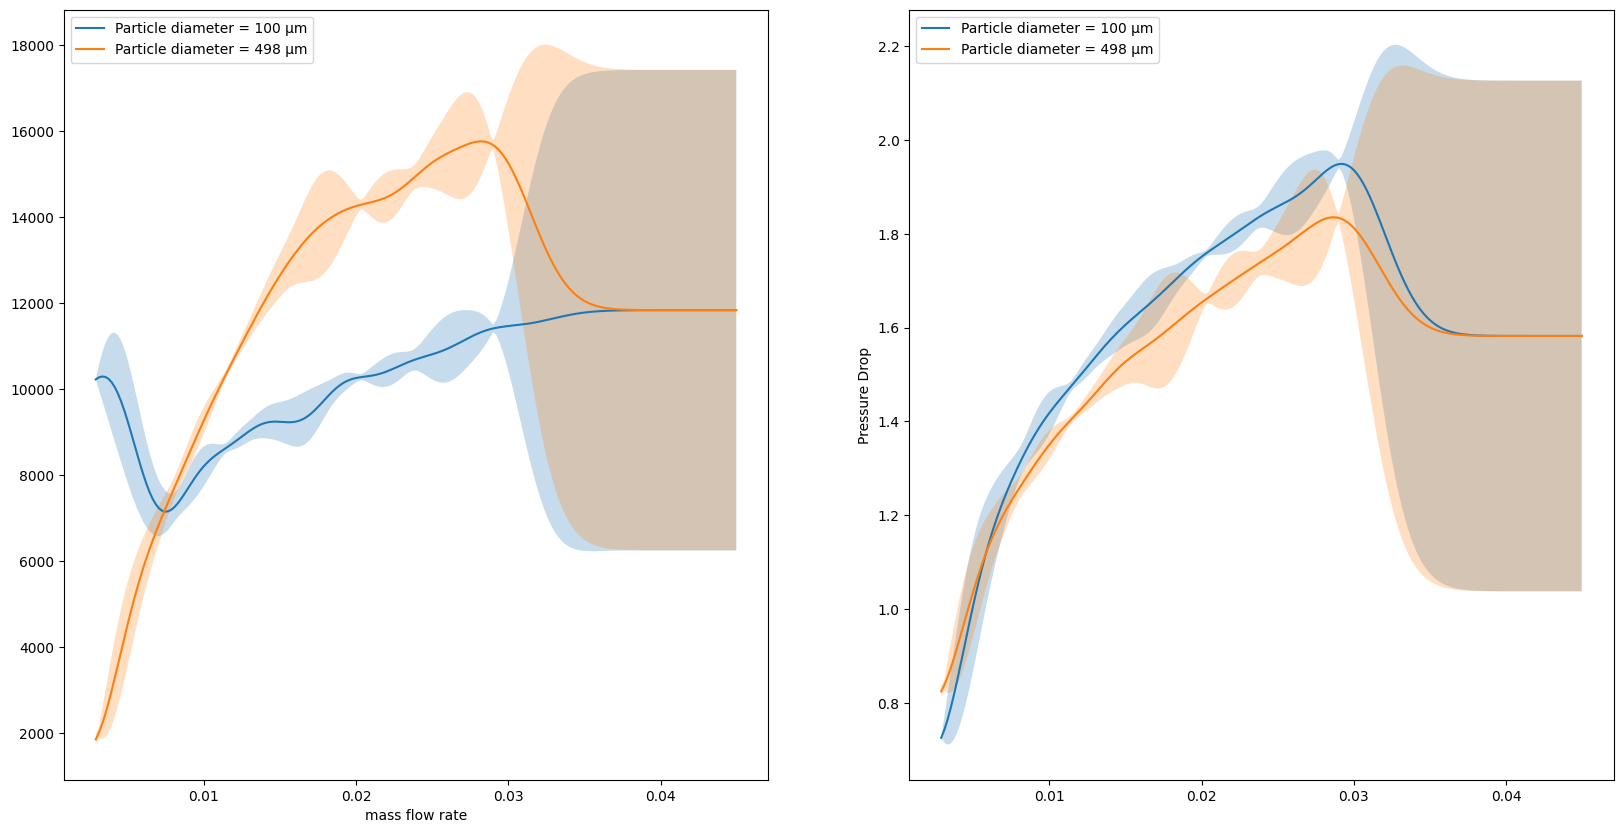

In [ ]:
fig, chart = plt.subplots(1, 2)

for dp in dp_values_m:
    xdat = np.vstack([mass_flow_range, np.ones_like(mass_flow_range) * dp]).T
    print(xdat.shape)
    ydat, std_dat = descaler_gp(
        GP.predict(scaler(xdat, mean_X, std_X), return_std=True), mean_y, std_y
    )

    UQ_u = ydat + 1.96 * std_dat
    UQ_l = ydat - 1.96 * std_dat

    chart[0].plot(xdat[:, 0], ydat[:, 0], label=f"Particle diameter = {dp*1e6:.0f} µm")
    if n_diameters_to_plot <= 2:
        chart[0].fill_between(
            xdat[:, 0],
            UQ_u[:, 0],
            UQ_l[:, 0],
            alpha=0.25,
            label=f"95% CI for {dp*1e6:.0f}",
        )

    chart[1].plot(xdat[:, 0], ydat[:, 1], label=f"Particle diameter = {dp*1e6:.0f} µm")
    if n_diameters_to_plot <= 2:
        chart[1].fill_between(
            xdat[:, 0],
            UQ_u[:, 1],
            UQ_l[:, 1],
            alpha=0.25,
            label=f"95% CI for {dp*1e6:.0f}",
        )


fig.set_figheight(10)
fig.set_figwidth(20)

chart[0].legend()
chart[1].legend()
chart[0].set_xlabel("mass flow rate")
chart[0].set_xlabel("mass flow rate")
chart[1].set_ylabel("bed height")
chart[1].set_ylabel("Pressure Drop")

In [41]:
y_pred, y_std = GP.predict(X_test, return_std=True)

# Descaling
y_pred = y_pred * std_y + mean_y
y_std = y_std * std_y

X_test = X_test * std_X + mean_X